##Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

Actinic keratosis

Basal cell carcinoma

Dermatofibroma

Melanoma

Nevus

Pigmented benign keratosis

Seborrheic keratosis

Squamous cell carcinoma

Vascular lesion

In [86]:
%tensorflow_version 2.x

In [87]:
# lets import all the necessary packages
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

In [88]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from glob import glob

import warnings
warnings.filterwarnings('ignore')

# Data Reading/Data Understanding

Defining the path for train and test images 

In [22]:
# importing using google colab
from google.colab import drive

#mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# providing root path
root_path = '/content/drive/MyDrive/dataset'

In [24]:
# making use of train test data
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [25]:
# lets count the number of images on train data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [26]:
# lets count the number of images on test data
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


# Dataset Creation

Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

In [29]:
img_height = 180
img_width = 180
batch_size = 32

In [30]:
# lets split data into 8:2 ratio, i.e, 80% 20%
# training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [31]:
# validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [33]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)

Found 118 files belonging to 9 classes.


In [34]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


In [35]:
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [36]:
dataset = tf.data.Dataset.range(10)
print(list(dataset.as_numpy_iterator()))
dataset1 = dataset.take(3)
print(list(dataset1.as_numpy_iterator()))
dataset2 = dataset.take(5)
print(list(dataset2.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2]
[0, 1, 2, 3, 4]


In [37]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#Dataset visualisation 

Create a code to visualize one instance of all the nine classes present in the dataset 


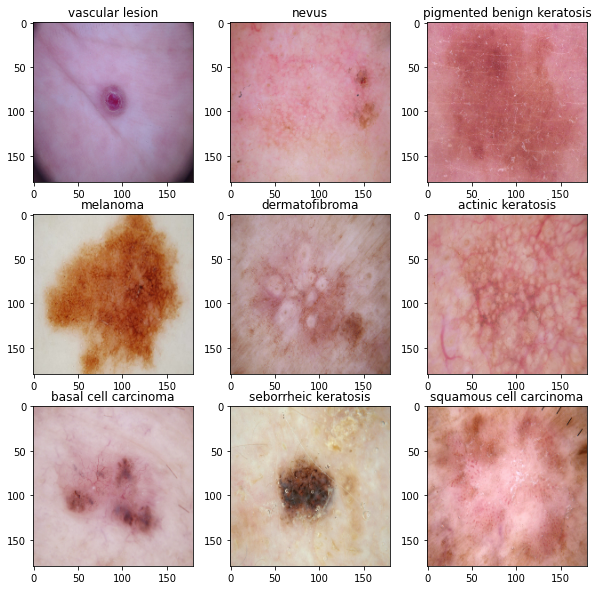

In [38]:
plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
    # print(images," | ",labels)
      # print(images.shape)
      # print(images[0].shape)
      # plt.figure(figsize=(20,20))
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(3,3,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
  else:
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [39]:
dataset = tf.data.Dataset.range(5)
print(list(dataset.as_numpy_iterator()))
dataset = dataset.map(lambda x: x**2)
print(list(dataset.as_numpy_iterator()))
dataset = dataset.cache()

print(list(dataset.as_numpy_iterator()))

print(list(dataset.as_numpy_iterator()))

[0, 1, 2, 3, 4]
[0, 1, 4, 9, 16]
[0, 1, 4, 9, 16]
[0, 1, 4, 9, 16]


In [40]:
dataset = tf.data.Dataset.range(3)
print(list(dataset.as_numpy_iterator()))
dataset = dataset.prefetch(2)
print(list(dataset.as_numpy_iterator()))

[0, 1, 2]
[0, 1, 2]


In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [42]:
### Your code goes here
num_classes = 9

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])


## Compile the model

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Train the model

In [45]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 242s 1s/step - loss: 3.4980 - accuracy: 0.1892 - val_loss: 2.1032 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 3s 58ms/step - loss: 1.9624 - accuracy: 0.2344 - val_loss: 2.0428 - val_accuracy: 0.2483
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 1.8270 - accuracy: 0.3382 - val_loss: 1.7968 - val_accuracy: 0.3311
Epoch 4/20
56/56 [==============================] - 3s 58ms/step - loss: 1.6298 - accuracy: 0.4269 - val_loss: 1.6827 - val_accuracy: 0.4049
Epoch 5/20
56/56 [==============================] - 3s 58ms/step - loss: 1.5010 - accuracy: 0.4654 - val_loss: 1.4907 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 3s 58ms/step - loss: 1.3971 - accuracy: 0.5167 - val_loss: 1.5091 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 3s 58ms/step - loss: 1.2848 - accuracy: 0.5530 - val_loss: 1.5325 - val_accuracy: 0.4407
Epoch 8/20
56

### Visualizing training results

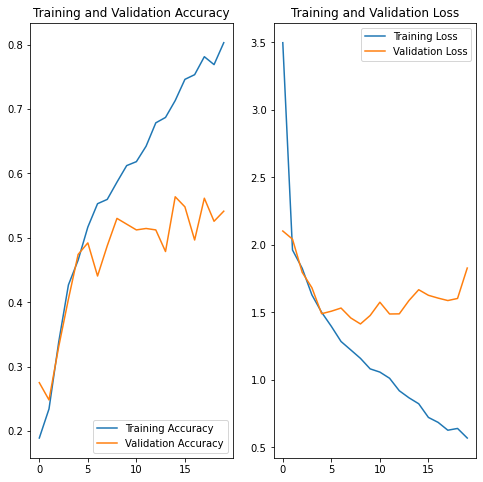

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  # print(model.predict_classes(images))
  # print(labels.numpy())
  y_true=list(labels.numpy())
  y_pred = np.argmax(model.predict(images),axis=1)
print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)
  

Accuracy on test dataset :  0.3474576271186441
                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.06      0.12        16
      basal cell carcinoma       0.30      0.44      0.36        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.20      0.25      0.22        16
                     nevus       0.31      0.69      0.42        16
pigmented benign keratosis       0.48      0.81      0.60        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.43      0.19      0.26        16
           vascular lesion       1.00      0.67      0.80         3

                  accuracy                           0.35       118
                 macro avg       0.41      0.34      0.31       118
              weighted avg       0.39      0.35      0.29       118

********************


In [48]:
# adding epochs and another opitmizer to same model

num_classes = 9

model_rmsprop = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_rmsprop.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
history_rmsprop = model_rmsprop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
56/56 [==============================] - 4s 64ms/step - loss: 4.4328 - accuracy: 0.1953 - val_loss: 2.0636 - val_accuracy: 0.2841
Epoch 2/30
56/56 [==============================] - 3s 61ms/step - loss: 2.0246 - accuracy: 0.2679 - val_loss: 2.0402 - val_accuracy: 0.2550
Epoch 3/30
56/56 [==============================] - 3s 61ms/step - loss: 1.8842 - accuracy: 0.3086 - val_loss: 1.8849 - val_accuracy: 0.3221
Epoch 4/30
56/56 [==============================] - 3s 61ms/step - loss: 1.7520 - accuracy: 0.3622 - val_loss: 1.7695 - val_accuracy: 0.3579
Epoch 5/30
56/56 [==============================] - 3s 60ms/step - loss: 1.6801 - accuracy: 0.4213 - val_loss: 1.5869 - val_accuracy: 0.4452
Epoch 6/30
56/56 [==============================] - 3s 61ms/step - loss: 1.6050 - accuracy: 0.4643 - val_loss: 1.5756 - val_accuracy: 0.4787
Epoch 7/30
56/56 [==============================] - 3s 61ms/step - loss: 1.5062 - accuracy: 0.4838 - val_loss: 1.6684 - val_accuracy: 0.3982
Epoch 8/30
56

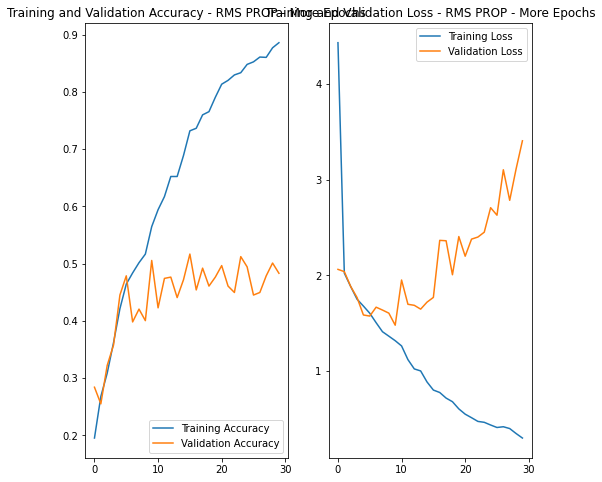

In [49]:
#visualizing

acc = history_rmsprop.history['accuracy']
val_acc = history_rmsprop.history['val_accuracy']

loss = history_rmsprop.history['loss']
val_loss = history_rmsprop.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - RMS PROP - More Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - RMS PROP - More Epochs')
plt.show()

In [50]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  # print(model.predict_classes(images))
  # print(labels.numpy())
  y_true=list(labels.numpy())
  y_pred = np.argmax(model.predict(images),axis=1)
print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)




Accuracy on test dataset :  0.3474576271186441
                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.06      0.12        16
      basal cell carcinoma       0.30      0.44      0.36        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.20      0.25      0.22        16
                     nevus       0.31      0.69      0.42        16
pigmented benign keratosis       0.48      0.81      0.60        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.43      0.19      0.26        16
           vascular lesion       1.00      0.67      0.80         3

                  accuracy                           0.35       118
                 macro avg       0.41      0.34      0.31       118
              weighted avg       0.39      0.35      0.29       118

********************


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Findings 

- we have included different epochs ( in this case 20, 30 ) and optimizers such as adams and rmsprop
-  we see an increase in accuracy until 6 to 7 epochs
- we see overfitting here

In [89]:
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

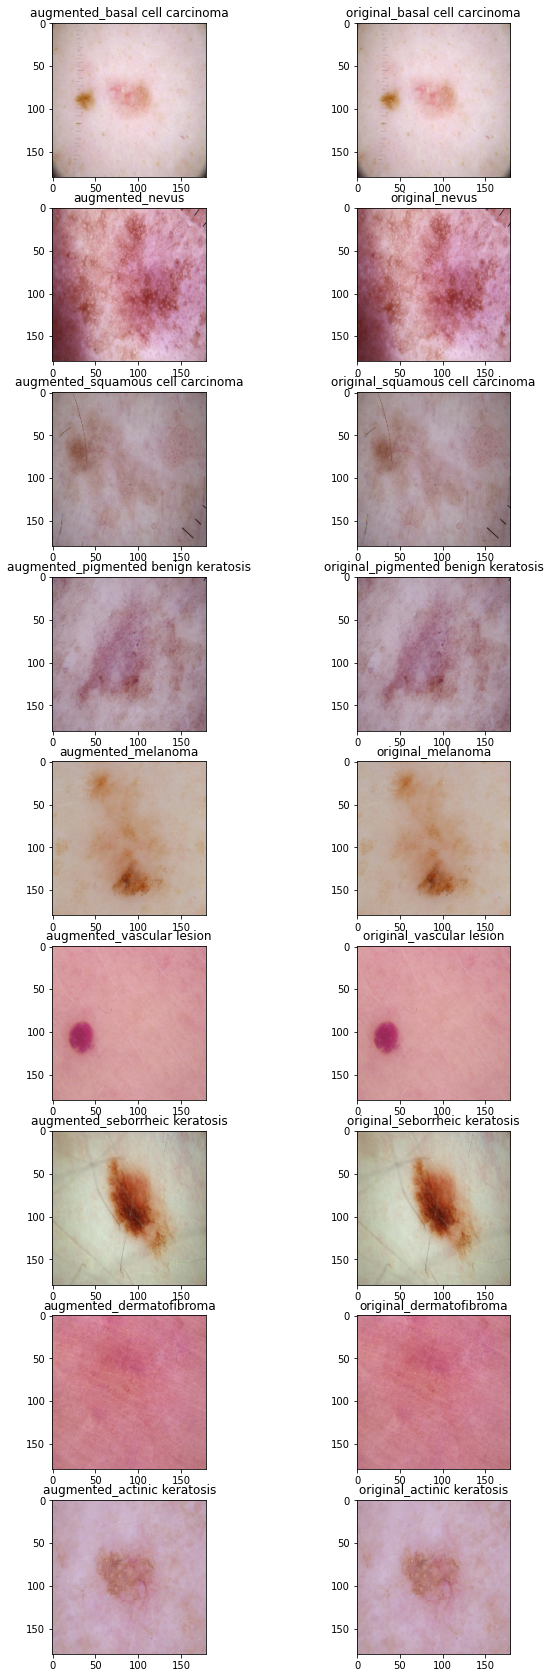

In [52]:
plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,30))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
    # print(images," | ",labels)
      # print(images.shape)
      # print(images[0].shape)
      # plt.figure(figsize=(20,20))
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(9,2,plot_idx+1)
        x=data_aug(images)
        plt.imshow(x[i].numpy().astype("uint8"));
        # plt.imshow(images[i].numpy().astype("uint8"));
        plt.title("augmented_"+class_names[labels[i]])
        plot_idx+=1
        plt.subplot(9,2,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("original_"+class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
        
  else:
    break


### Todo:
### Create the model, compile and train the model


In [53]:
model = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])


### Compiling the model

In [54]:
## Your code goes here
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

### Training the model

In [55]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 64ms/step - loss: 3.4190 - accuracy: 0.1652 - val_loss: 2.1377 - val_accuracy: 0.2148
Epoch 2/20
56/56 [==============================] - 3s 60ms/step - loss: 2.0590 - accuracy: 0.2065 - val_loss: 2.0839 - val_accuracy: 0.1902
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 2.0256 - accuracy: 0.2026 - val_loss: 2.0633 - val_accuracy: 0.1633
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 2.0123 - accuracy: 0.2277 - val_loss: 2.0663 - val_accuracy: 0.1767
Epoch 5/20
56/56 [==============================] - 3s 61ms/step - loss: 1.9386 - accuracy: 0.2913 - val_loss: 2.0341 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 3s 61ms/step - loss: 1.8821 - accuracy: 0.3231 - val_loss: 1.7930 - val_accuracy: 0.3512
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 1.6748 - accuracy: 0.3901 - val_loss: 1.6255 - val_accuracy: 0.4541
Epoch 8/20
56

### Visualizing the results

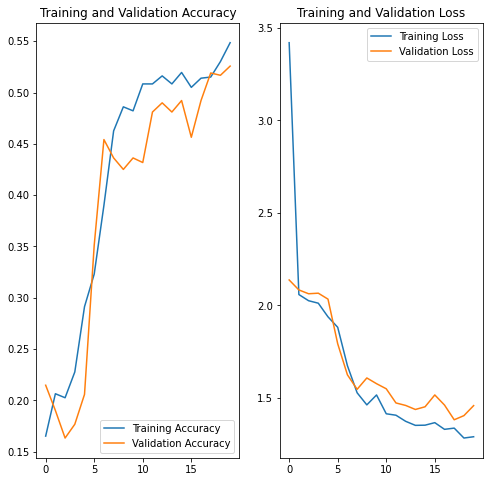

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
# different optimizer
model_aug_adagrad = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_aug_adagrad.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history_aug_adagrad = model_aug_adagrad.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/25
56/56 [==============================] - 4s 63ms/step - loss: 2.0562 - accuracy: 0.1959 - val_loss: 2.0579 - val_accuracy: 0.1790
Epoch 2/25
56/56 [==============================] - 3s 61ms/step - loss: 2.0306 - accuracy: 0.2026 - val_loss: 2.0517 - val_accuracy: 0.3333
Epoch 3/25
56/56 [==============================] - 3s 61ms/step - loss: 2.0148 - accuracy: 0.2327 - val_loss: 2.0527 - val_accuracy: 0.2371
Epoch 4/25
56/56 [==============================] - 3s 61ms/step - loss: 2.0008 - accuracy: 0.2433 - val_loss: 2.0371 - val_accuracy: 0.3110
Epoch 5/25
56/56 [==============================] - 3s 61ms/step - loss: 1.9851 - accuracy: 0.2812 - val_loss: 2.0174 - val_accuracy: 0.3177
Epoch 6/25
56/56 [==============================] - 3s 61ms/step - loss: 1.9643 - accuracy: 0.2963 - val_loss: 1.9893 - val_accuracy: 0.3468
Epoch 7/25
56/56 [==============================] - 3s 61ms/step - loss: 1.9454 - accuracy: 0.2952 - val_loss: 1.9876 - val_accuracy: 0.2662
Epoch 8/25
56

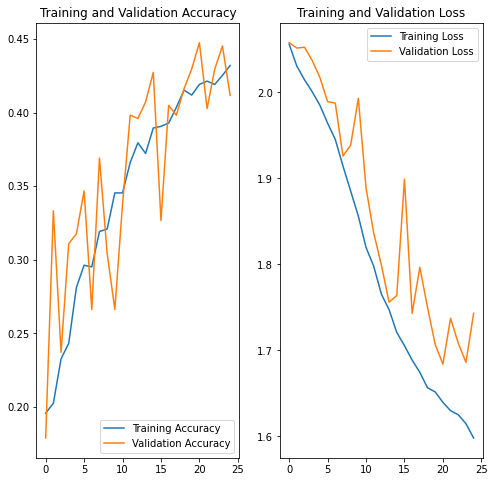

In [58]:
# creating a performance visualisation for adagrad optimiser
acc = history_aug_adagrad.history['accuracy']
val_acc = history_aug_adagrad.history['val_accuracy']

loss = history_aug_adagrad.history['loss']
val_loss = history_aug_adagrad.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
# creating another model with SGD opitmizer
model_aug_sgd = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_aug_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history_aug_sgd = model_aug_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 4s 62ms/step - loss: 2.0645 - accuracy: 0.1964 - val_loss: 2.0343 - val_accuracy: 0.2304
Epoch 2/25
56/56 [==============================] - 3s 60ms/step - loss: 2.0056 - accuracy: 0.2584 - val_loss: 2.0667 - val_accuracy: 0.2148
Epoch 3/25
56/56 [==============================] - 3s 60ms/step - loss: 1.9727 - accuracy: 0.2556 - val_loss: 2.0179 - val_accuracy: 0.2617
Epoch 4/25
56/56 [==============================] - 3s 60ms/step - loss: 1.9574 - accuracy: 0.2790 - val_loss: 1.9484 - val_accuracy: 0.2998
Epoch 5/25
56/56 [==============================] - 3s 60ms/step - loss: 1.9014 - accuracy: 0.3092 - val_loss: 1.8132 - val_accuracy: 0.3669
Epoch 6/25
56/56 [==============================] - 3s 60ms/step - loss: 1.8627 - accuracy: 0.3343 - val_loss: 1.7701 - val_accuracy: 0.3781
Epoch 7/25
56/56 [==============================] - 3s 60ms/step - loss: 1.8615 - accuracy: 0.3119 - val_loss: 2.0453 - val_accuracy: 0.1745
Epoch 8/25
56

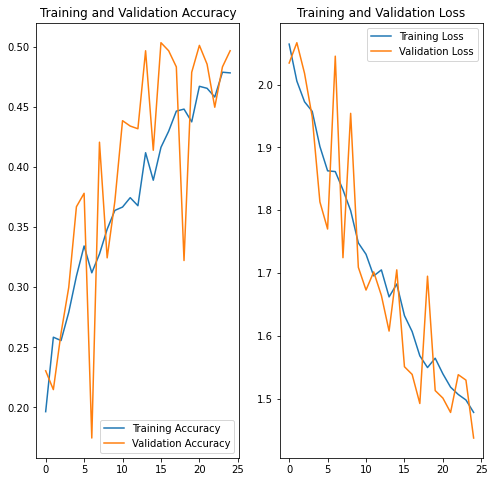

In [60]:
# performance visualisation for sgd optimizer
acc = history_aug_sgd.history['accuracy']
val_acc = history_aug_sgd.history['val_accuracy']

loss = history_aug_sgd.history['loss']
val_loss = history_aug_sgd.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
# performance on the test set 
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  # print(model.predict_classes(images))
  # print(labels.numpy())
  y_true=list(labels.numpy())
  y_pred=y_pred = np.argmax(model.predict(images),axis=1)
  # break
  print("Adam optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_aug_adagrad.predict(images),axis =1)
  # break
  print("Adagrad optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_aug_sgd.predict(images),axis =1)
  # break
  print("SGD optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)



  

Adam optimizer
                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.06      0.12        16
      basal cell carcinoma       0.33      0.62      0.43        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.12      0.12      0.12        16
                     nevus       0.45      0.94      0.61        16
pigmented benign keratosis       0.35      0.75      0.48        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.36       118
                 macro avg       0.33      0.35      0.27       118
              weighted avg       0.32      0.36      0.26       118

Accuracy on test dataset :  0.3559322033898305
********************
Adagrad optimizer
            

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


## Findings

- we reduced overfitting with a few agumentation layer addition but still model is lacking a bit
- eventhough we did use different set of adagrad, optmizers sgd and adams we saw low accuracy

In [62]:
train_path_list = list(data_dir_train.glob('*/*.jpg'))

In [63]:
# dct={}
# for x in train_path_list:
#   result=str(x).split("/")
#   if result[2] in dct.keys():
#     dct[result[2]]+=1
#   else:
#     dct[result[2]]=1

In [64]:
# cancer=[]
# count=[]
# for k,v in dct.items():
#   cancer.append(k)
#   count.append(v)

df=pd.DataFrame({"cancer_type":[str(x).split("/")[2] for x in train_path_list]})

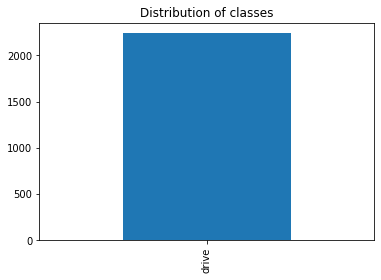

In [65]:
df['cancer_type'].value_counts().plot(kind='bar')
plt.title("Distribution of classes")
plt.show()

In [66]:
## Your code goes here.
# dataframe_dict_original = dict(zip(path_list, lesion_list))
# original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
# original_df

## Findings
## Which class has the least number of samples?
### seborrheic keratosis
## Which classes dominate the data in terms proportionate number of samples?
### pigmented benign keratosis


### Rectify the class imbalance

In [67]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
path_to_training_dataset= pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3C822D4ED0>: 100%|██████████| 500/500 [00:22<00:00, 22.46 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C823C5D90>: 100%|██████████| 500/500 [00:22<00:00, 22.13 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C82329B50>: 100%|██████████| 500/500 [00:23<00:00, 21.63 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3C7F918410>: 100%|██████████| 500/500 [01:43<00:00,  4.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3C82262990>: 100%|██████████| 500/500 [01:35<00:00,  5.25 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C8212B290>: 100%|██████████| 500/500 [00:19<00:00, 25.82 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3DA9DF1790>: 100%|██████████| 500/500 [00:43<00:00, 11.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3C7F8F9ED0>: 100%|██████████| 500/500 [00:19<00:00, 26.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C82255550>: 100%|██████████| 500/500 [00:19<00:00, 25.75 Samples/s]


In [69]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [70]:
from glob import glob

#### augmented data after adding new images

In [71]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

In [72]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [73]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [74]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2) 

In [75]:
#created 500 samples for each
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
melanoma                      500
vascular lesion               500
dermatofibroma                500
pigmented benign keratosis    500
seborrheic keratosis          500
nevus                         500
squamous cell carcinoma       500
Name: Label, dtype: int64

In [76]:
#new counts
new_list=list(df['cancer_type'].values)
new_list.extend(list(df2['Label'].values))
len(new_list)
final_df=pd.DataFrame({"cancer_type":new_list})
final_df['cancer_type'].value_counts()

drive                         2239
actinic keratosis              500
basal cell carcinoma           500
melanoma                       500
vascular lesion                500
dermatofibroma                 500
pigmented benign keratosis     500
seborrheic keratosis           500
nevus                          500
squamous cell carcinoma        500
Name: cancer_type, dtype: int64

- We have added images to all the classes to maintainbalance. 
- We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [77]:
batch_size = 32
img_height = 180
img_width = 180

###  Create a training dataset

In [78]:
data_dir_train=pathlib.Path(root_path + '/Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


###  Create a validation dataset

In [79]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model ( normalization)

In [80]:
## your code goes here
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.40),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.40),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

### Compile model

In [81]:
## your code goes here
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 90, 90, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

### Train

In [82]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 34s 190ms/step - loss: 2.7171 - accuracy: 0.1664 - val_loss: 2.0777 - val_accuracy: 0.1938
Epoch 2/50
169/169 [==============================] - 32s 186ms/step - loss: 1.9066 - accuracy: 0.2786 - val_loss: 1.8240 - val_accuracy: 0.3200
Epoch 3/50
169/169 [==============================] - 33s 187ms/step - loss: 1.5115 - accuracy: 0.4534 - val_loss: 1.4519 - val_accuracy: 0.4684
Epoch 4/50
169/169 [==============================] - 33s 187ms/step - loss: 1.2735 - accuracy: 0.5397 - val_loss: 1.3657 - val_accuracy: 0.4811
Epoch 5/50
169/169 [==============================] - 32s 185ms/step - loss: 1.0964 - accuracy: 0.5976 - val_loss: 1.1614 - val_accuracy: 0.5939
Epoch 6/50
169/169 [==============================] - 34s 193ms/step - loss: 0.9697 - accuracy: 0.6467 - val_loss: 1.1001 - val_accuracy: 0.6236
Epoch 7/50
169/169 [==============================] - 32s 186ms/step - loss: 0.8026 - accuracy: 0.7094 - val_loss: 0.9793 - val_ac

### Visualize

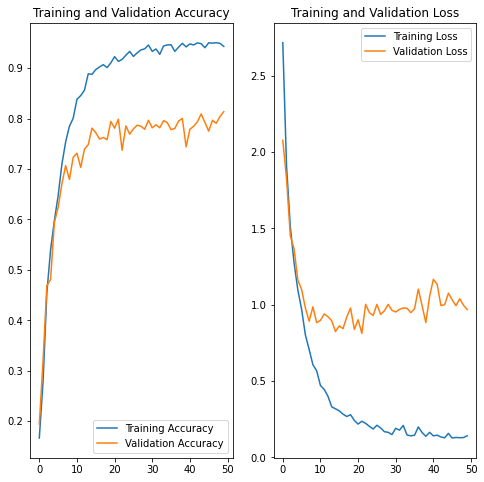

In [83]:
# plot for ADaM optimizer
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [84]:
# different model optimizer 
model_imbalance_sgd = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_imbalance_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
## Your code goes here, use 50 epochs.
history_imbalance_sgd = model_imbalance_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 186ms/step - loss: 2.1672 - accuracy: 0.1664 - val_loss: 2.1416 - val_accuracy: 0.1886
Epoch 2/30
169/169 [==============================] - 33s 187ms/step - loss: 2.0765 - accuracy: 0.2111 - val_loss: 2.0638 - val_accuracy: 0.2086
Epoch 3/30
169/169 [==============================] - 32s 183ms/step - loss: 1.9853 - accuracy: 0.2441 - val_loss: 2.1791 - val_accuracy: 0.1678
Epoch 4/30
169/169 [==============================] - 32s 186ms/step - loss: 1.8929 - accuracy: 0.2784 - val_loss: 1.9030 - val_accuracy: 0.3022
Epoch 5/30
169/169 [==============================] - 32s 185ms/step - loss: 1.7778 - accuracy: 0.3444 - val_loss: 1.6680 - val_accuracy: 0.3868
Epoch 6/30
169/169 [==============================] - 33s 192ms/step - loss: 1.6851 - accuracy: 0.3793 - val_loss: 1.6748 - val_accuracy: 0.3801
Epoch 7/30
169/169 [==============================] - 32s 183ms/step - loss: 1.5916 - accuracy: 0.4121 - val_loss: 1.5926 - val_ac

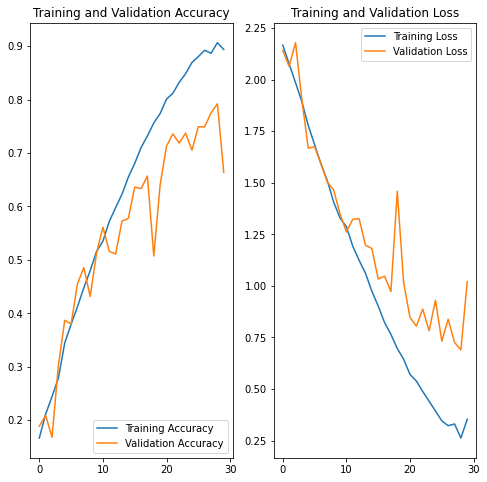

In [85]:
# SGD optimizer plot
acc = history_imbalance_sgd.history['accuracy']
val_acc = history_imbalance_sgd.history['val_accuracy']

loss = history_imbalance_sgd.history['loss']
val_loss = history_imbalance_sgd.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Process so far 

- we have used the model with different epoch (30,50) and optimizers (adam, sgd ) 
- In the very begining we used a model with adam optimizer with 50 epochs which resulted in a good accuracy

###  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Result

- we have used the model with different epoch (30,50,30) and optimizers (adam, sgd ) 
- In the very begining we used a model with adam optimizer with 50 epochs which resulted in a good accuracy
- we handled imbalance by adding augmented images
- we worked on overfitting
- train accuracy is around 90% and validation accuracy 80%
- performance was good
- learning rate is good for initial 20 epochs but gradually slows down